In [12]:
from google.cloud import bigquery
from google.cloud import storage
from google.oauth2 import service_account

In [13]:
credentials = service_account.Credentials.from_service_account_file(
    './My Project 18021-e0a14e0a0015.json',
    scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

client = bigquery.Client(
    credentials=credentials,
    project=credentials.project_id,
)

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from tqdm import tqdm_notebook

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, recall_score, precision_score,roc_curve, f1_score, roc_auc_score

In [16]:
#balance queries demonstrating preseveration of value
sql = '''
WITH double_entry_book AS (
   -- debits
   SELECT
    array_to_string(inputs.addresses, ",") as address
   , inputs.type
   , -inputs.value as value
   FROM `bigquery-public-data.crypto_bitcoin.inputs` as inputs
   UNION ALL
   -- credits
   SELECT
    array_to_string(outputs.addresses, ",") as address
   , outputs.type
   , outputs.value as value
   FROM `bigquery-public-data.crypto_bitcoin.outputs` as outputs
)
SELECT
   address
,   type   
,   sum(value) as balance
FROM double_entry_book
GROUP BY 1,2
ORDER BY balance DESC
LIMIT 100000
'''

In [17]:
df1 = client.query(sql).to_dataframe()

In [18]:
df1.head(5)

,address,type,balance
0,35hK24tcLEWcgNA4JxpvbkNkoAcDGqQPsP,scripthash,25550215632356
1,bc1qgdjqv0av3q56jvd82tkdjpy7gdp9ut8tlqmgrpmv24...,witness_v0_scripthash,11350099940517
2,3KZ526NxCVXbKwwP66RgM3pte6zW4gY1tD,scripthash,10185724740701
3,37XuVSEpWW4trkfmvWzegTHQt7BdktSKUs,scripthash,9450577228129
4,37do5d3pKeCuozjNCApGT153GJ8oNmKYbB,scripthash,8898956701196


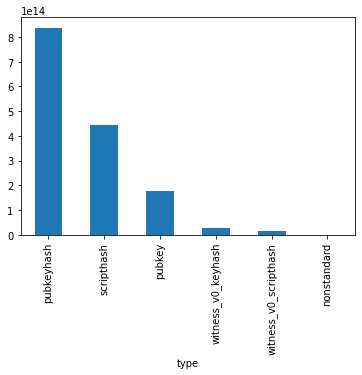

In [19]:
df1['balance']=df1['balance'].astype('int')
df1.groupby(['type'])['balance'].sum().sort_values(ascending=False).plot(kind='bar')

In [20]:
df1.describe()

,balance
count,1.000000e+05
mean,1.500189e+10
std,1.399884e+11
min,2.000000e+09
25%,3.404647e+09
50%,5.000000e+09
75%,5.699837e+09
max,2.555022e+13


In [21]:
# the tranction fees on the bitcoin network
sql = '''
SELECT 
  ROUND((input_value - output_value)/ size, 0) AS fees_per_byte,
  COUNT(*) AS txn_cnt
FROM
  `bigquery-public-data.crypto_bitcoin.transactions`
WHERE TRUE
  AND block_timestamp >= '2017-05-01' 
  AND is_coinbase IS FALSE
GROUP BY 1
'''

In [22]:
df2 = client.query(sql).to_dataframe()

In [23]:
df2.fees_per_byte = df2.fees_per_byte.astype(float)
df2.txn_cnt = df2.txn_cnt.astype(float)
df2.sort_values(by='fees_per_byte',ascending=False)

,fees_per_byte,txn_cnt
4257,905650.0,1.0
7135,886913.0,1.0
2960,782299.0,1.0
4456,652648.0,1.0
7706,641259.0,1.0
...,...,...
12078,4.0,9287793.0
11134,3.0,21065838.0
6819,2.0,8100518.0
10684,1.0,19198339.0


**From the table,outside the transaction platform coinbase, we can see high trsaction fees has less transaction 
frequency, and low transaction fee has high frequency. What dose this indicate?**
+ A small portion of users use bitcoin to do large amount of money transfering only for 1 or serveral times, possible money laundrying. 
+ Most of the users are transfering coins at high frequent at a very small amount, possibly normal transactions.

In [26]:
# the trandaction times of unique address
sql = '''
SELECT
    txn_count,
    COUNT(txn_count) AS num_addresses
FROM
(
    SELECT 
    ARRAY_TO_STRING(inputs.addresses, '') AS addresses,
    COUNT(DISTINCT `hash`) AS txn_count
    FROM `bigquery-public-data.crypto_bitcoin.transactions` AS txns
    CROSS JOIN UNNEST(txns.inputs) AS inputs
    GROUP BY addresses
)
GROUP BY txn_count
ORDER BY txn_count ASC
'''

In [27]:
df3 = client.query(sql).to_dataframe()

In [34]:
df3.sample(5)

,txn_count,num_addresses
1404,1405,7
3270,3492,1
4280,5422,1
5560,12611,1
3435,3739,2


Text(0, 0.5, 'frquency')

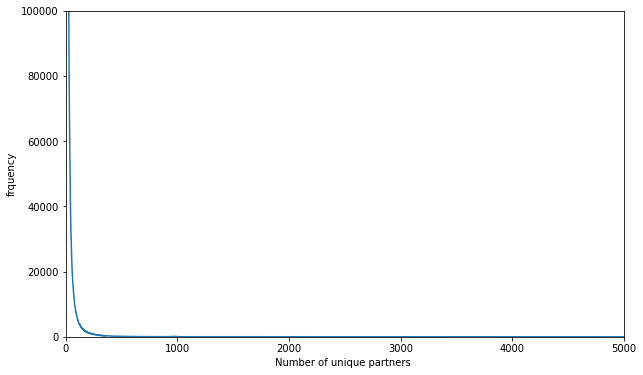

In [44]:
plt.figure(figsize=(10,6))
plt.plot(df3['txn_count'],df3['num_addresses'],)
plt.ylim([0,100000])
plt.xlim([0,5000])
plt.xlabel("Number of unique partners ")
plt.ylabel("frquency")

In [61]:
#see the trsanction connected with my ETH address
sql = '''
--second degree
SELECT

    tx.from_address, tx.to_address, SUM(tx.value)/POWER(10,18) AS value
  FROM `bigquery-public-data.crypto_ethereum.transactions` AS tx
  WHERE from_address IN (
    SELECT
      to_address
    FROM `bigquery-public-data.crypto_ethereum.transactions` AS tx
    WHERE
      from_address = '0x311ebadb10d50130833e0677602a1d9cea322d33'
  )
  GROUP BY from_address, to_address
--  HAVING COUNT(tx.to_address) > 1

UNION ALL

  --first degree
  SELECT
    from_address, to_address, SUM(tx.value)/POWER(10,18)
  FROM `bigquery-public-data.crypto_ethereum.transactions` AS tx
  WHERE
    from_address = '0x311ebadb10d50130833e0677602a1d9cea322d33'
  GROUP BY from_address, to_address
'''

In [62]:
df4 = client.query(sql).to_dataframe()

In [67]:
df4.head(5)

,from_address,to_address,value
0,0xf5613e4da78cee6a1bffdf9c235d56bbf6d01d8d,0xdcbc2ab350e3c51d992f3fd80ff804fb9e29ae12,10.246945
1,0xf5613e4da78cee6a1bffdf9c235d56bbf6d01d8d,0xbe65f45173fb1c3308b800ed7eab96643e7b2c49,1879.670000
2,0xf5613e4da78cee6a1bffdf9c235d56bbf6d01d8d,0x36e7ddfd381bb461ea98c3a6641fad67c7f314af,1.890000
3,0xf5613e4da78cee6a1bffdf9c235d56bbf6d01d8d,0xe71ff76bbc0621cf1caecd403b109a3d097fa0e3,0.028809
4,0xf5613e4da78cee6a1bffdf9c235d56bbf6d01d8d,0x6b99d744a689d23796c0427d7800a121c755b435,13.660000
